# Kalman filter for the SIR model

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
from src.data import SirModel
from src.visualisation import plot_progress, plot_param_process, plot_error, plot_param_distribution

In [2]:
save_dir = '../figures/sir/kalman'

## SIR model
First of all define the number of data $N$, the end time $T$ (note that the time intervall is $[0,T]$) and the varianz $\sigma_z$ of the the centered normal distributed noise term $z \sim \mathcal{N}(0, \sigma_z)$.

In [3]:
number_of_data = 100
end_time = 99
noise = 5

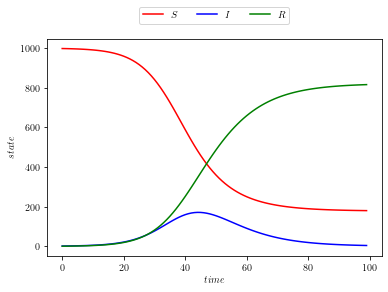

In [4]:
sir_true = SirModel(number_of_data=number_of_data,
                    end_time=end_time,
                    noise_variance=0.0,
                    param = {'beta': 0.3, 'gamma': 1/7},
                    initial_condition={'t': 0, 'y_1': 999.0, 'y_2': 1.0, 'y_3': 0.0})
sir_true.set_data()
sir_true.plot_data()

In [5]:
plt.rcParams.update({'font.size': 30,
                     'figure.figsize': (16, 8),
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{lmodern}', 
                     'font.weight': 'bold', 
                     "axes.labelweight": "bold"})

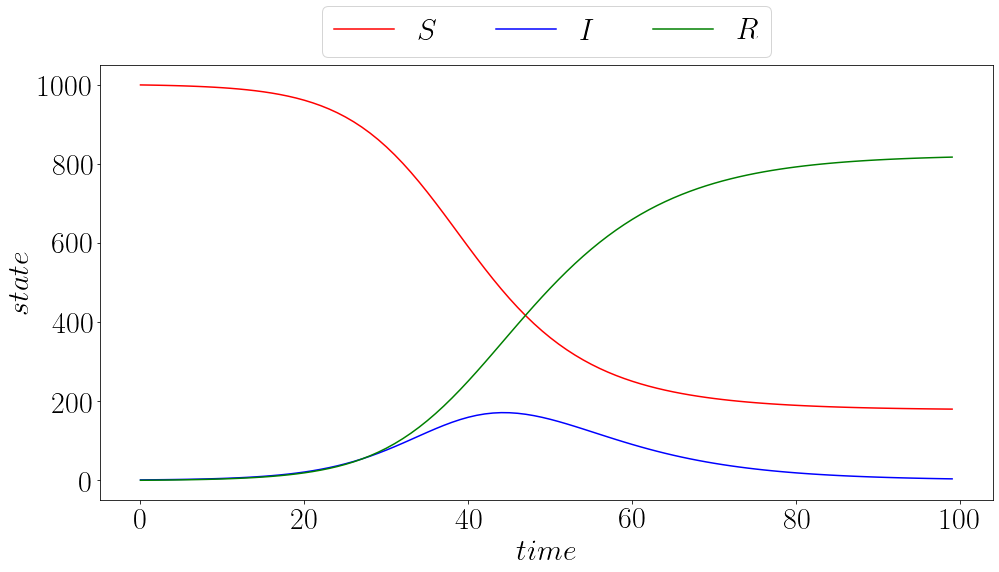

In [6]:
sir_true.plot_data(save_dir=save_dir)
sir_true.plot_data()

Generate the true unnoised values of the SIR model and plot them in 2d.

Now the noisy data is also generated. The model is then trained on this data.

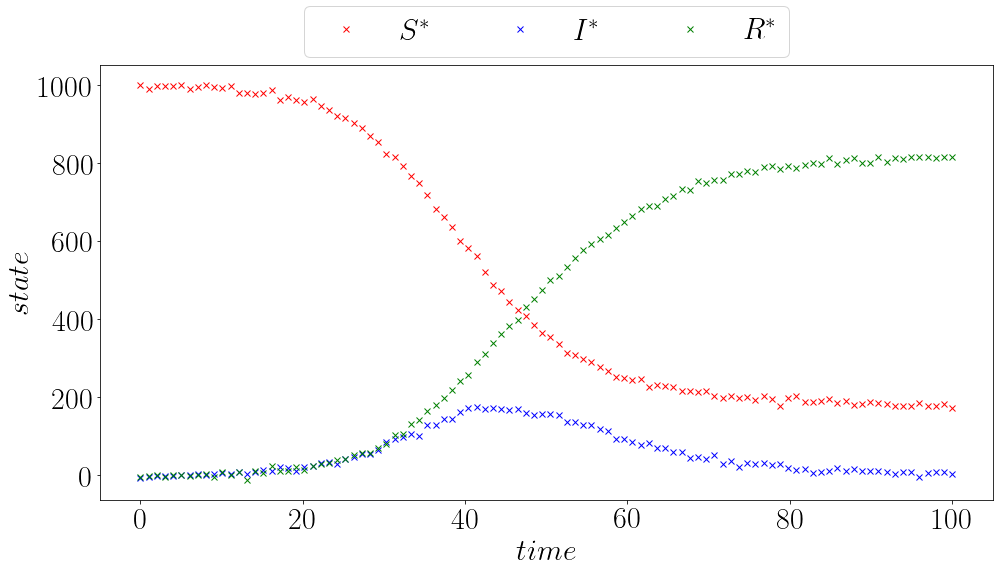

In [7]:
sir_noise = SirModel(number_of_data=100,
                     end_time=100,
                     noise_variance=noise,
                     param = {'beta': 0.3, 'gamma': 1/7},
                     initial_condition={'t': 0, 'y_1': 999.0, 'y_2': 1.0, 'y_3': 0.0})
sir_noise.set_data()
sir_noise.plot_data(save_dir=save_dir)
sir_noise.plot_data()

The deviation between true and noisy values is shown in the next figure.

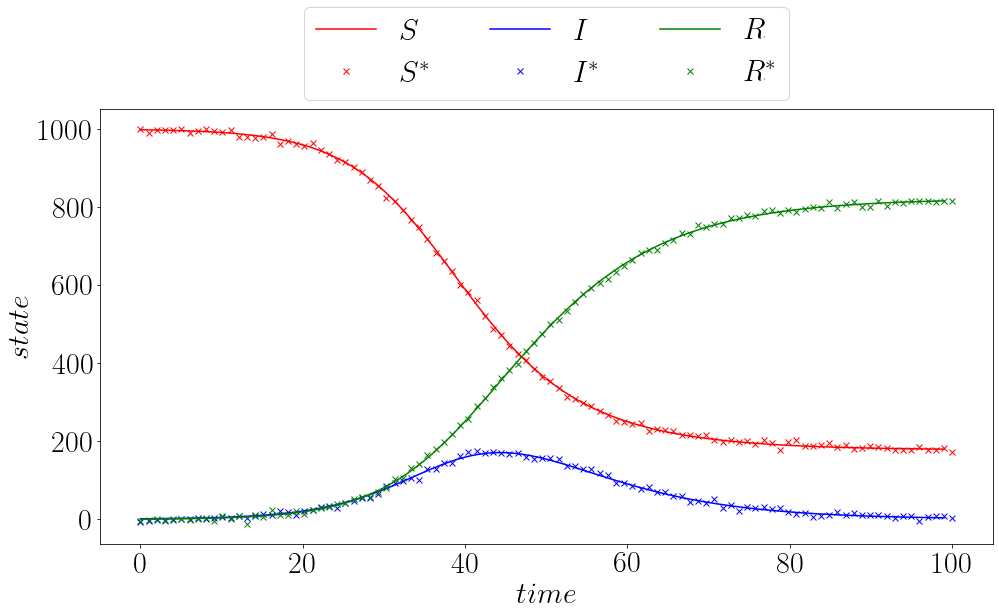

In [8]:
colors = ['r', 'b', 'g']
for i, col in enumerate(sir_true.data.columns):
    plt.plot(sir_true.data[col], colors[i])
    plt.plot(sir_noise.data[col], f"{colors[i]}x")
    plt.ylabel(r"$state$")
    plt.xlabel(r"$time$")
    legend = [r"$S$", r"$S^{\ast}$", r"$I$", r"$I^{\ast}$", r"$R$", r"$R^{\ast}$"]
    plt.legend(legend, ncol=3, loc='upper center',  bbox_to_anchor=(0.5, 1.27))
plt.savefig(f"{save_dir}/sir_2d_noise_with_true", dpi=300)
plt.show()

## Kalman filter
Since the data are already available, the kalman filter can now be created.

In [9]:
from src.kalmanfilter import KalmanFilter

In [10]:
kf = KalmanFilter(sir_noise)

Now it just needs to be trained.

In [11]:
df_train_param = kf.train(epochs=100000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3583.67it/s]


best parameter: {'beta': 0.28418734093669273, 'gamma': 0.1351296245487119}


In [12]:
analysis, forecast = kf.predict()

After that, we look at how well the states were predicted. As an aid, the predictions can be presented together with the observations and the underlying true values.

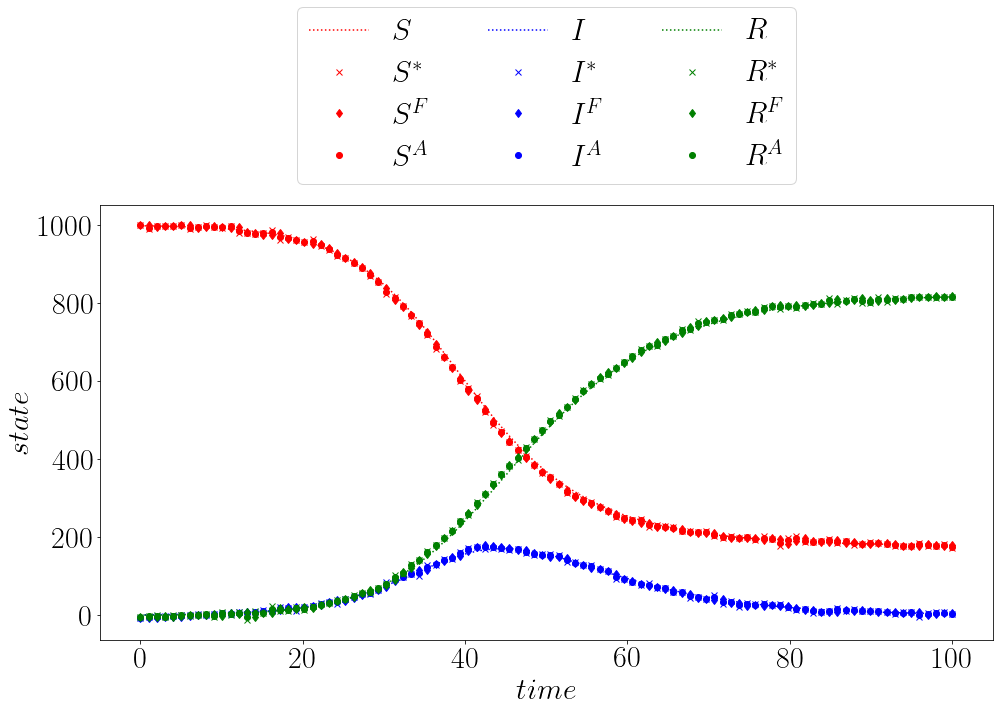

save figure to ../figures/sir/kalman/sir_kalman_progress


In [13]:
plot_progress(time=numpy.array([[t] for t in kf.input_data.index]),
              observation=kf.differential_equation.data,
              true=sir_true.data,
              prediction=forecast,
              analysis=analysis, 
              variables={'y_1': 'S', 'y_2': 'I', 'y_3': 'R'})
plot_progress(time=numpy.array([[t] for t in kf.input_data.index]),
              observation=kf.differential_equation.data,
              true=sir_true.data,
              prediction=forecast,
              analysis=analysis, 
              variables={'y_1': 'S', 'y_2': 'I', 'y_3': 'R'},
              save_path=f"{save_dir}/sir_kalman_progress")

Finally, we check how well the parameter estimation worked by plotting the development of the parameters over the epochs.
For comparison, the parameters with which the data were generated are also plotted.

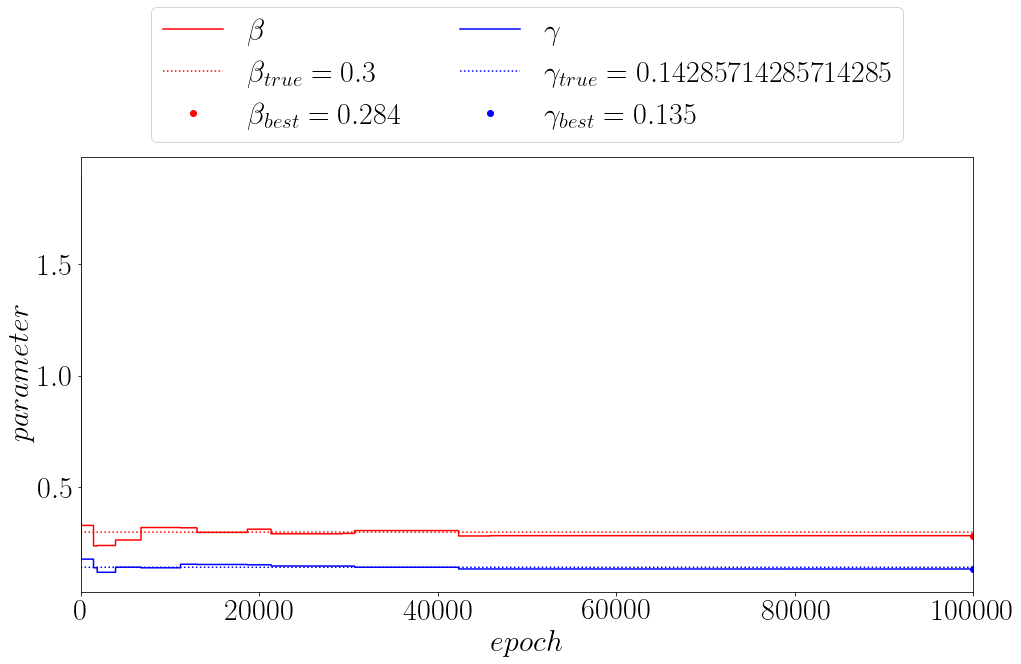

save figure to ../figures/sir/kalman/sir_kalman_param


In [14]:
plot_param_process(true_params=kf.differential_equation.param, 
                   df_progress=kf.df_progress)
plot_param_process(true_params=kf.differential_equation.param, 
                   df_progress=kf.df_progress, 
                   save_path=f"{save_dir}/sir_kalman_param")

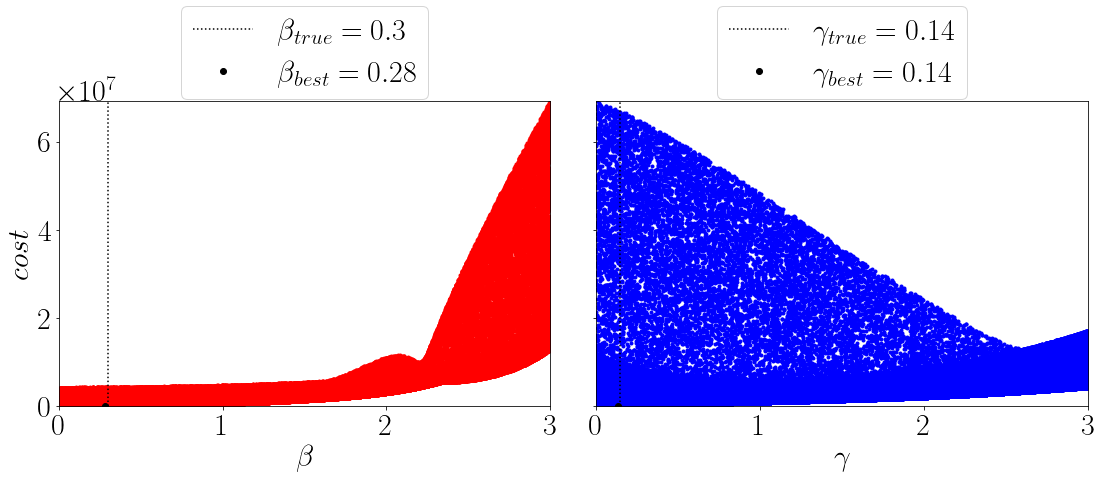

save figure to ../figures/sir/kalman/sir_kalman_param_distribution


In [15]:
plot_param_distribution(df_train_param, 
                        true_params=kf.differential_equation.param, 
                        best_params=kf.df_progress.iloc[-1].to_dict(), 
                        name='sir')
plot_param_distribution(df_train_param, 
                        true_params=kf.differential_equation.param, 
                        best_params=kf.df_progress.iloc[-1].to_dict(), 
                        name='sir',
                        save_path=f"{save_dir}/sir_kalman_param_distribution")

The cost per state is: 4.269792538827197.


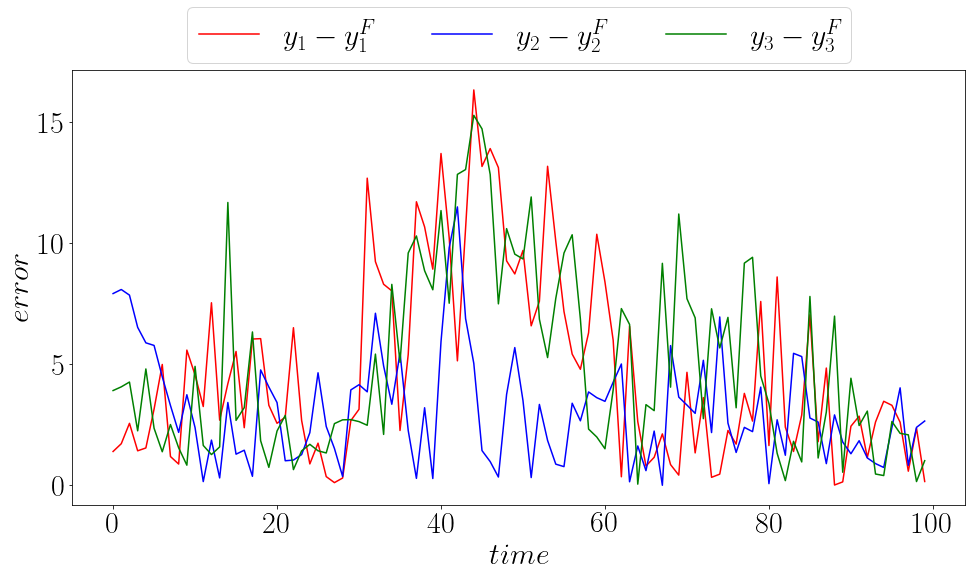

The cost per state is: 4.269792538827197.
save figure to ../figures/sir/kalman/sir_kalman_error


In [16]:
plot_error(sir_true.data, forecast[:,:3], name='kalman')
plot_error(sir_true.data, forecast[:,:3], name='kalman', 
           save_path=f"{save_dir}/sir_kalman_error")